In [1]:
import pandas as pd

In [2]:
df = pd.read_parquet("../../../data/data_taxi_central_based.parquet")
df = df[(df['POLYLINE_LENGTH'] >= 30) & (df['POLYLINE_LENGTH'] < 276)]

In [3]:
import timesfm

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.13 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:03:15) [MSC v.1929 64 bit (AMD64)].


In [4]:
df_lon = df.drop(columns=['ORIGIN_CALL', 'TAXI_ID', 'POLYLINE_LENGTH', 'LAT'])
df_lat = df.drop(columns=['ORIGIN_CALL', 'TAXI_ID', 'POLYLINE_LENGTH', 'LON'])

In [5]:
tfm_lat = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="cpu",
          per_core_batch_size=32,
          horizon_len=20,
          num_layers=50,
          use_positional_embedding=False,
          context_len=256,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          path="../../../models/TimesFMRetrained/TimesFM/timesfm_predictions_LAT.ckpt"),
  )

In [6]:
tfm_lon = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="cpu",
          per_core_batch_size=32,
          horizon_len=20,
          num_layers=50,
          use_positional_embedding=False,
          context_len=256,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          path="../../../models/TimesFMRetrained/TimesFM/timesfm_predictions_LON.ckpt"),
  )

In [7]:
df_lat = df_lat.sort_values(by=['TRIP_ID', 'TIMESTAMP'])
df_lat_test = df_lat.groupby('TRIP_ID', group_keys=False).tail(20)
df_lat_train = df_lat.drop(df_lat_test.index)

In [8]:
df_lon = df_lon.sort_values(by=['TRIP_ID', 'TIMESTAMP'])
df_lon_test = df_lon.groupby('TRIP_ID', group_keys=False).tail(20)
df_lon_train = df_lon.drop(df_lat_test.index)

In [9]:
from joblib import load
scaler_lat = load("../../../models/TimesFMRetrained/TimesFM/scaler_LAT.pkl")
df_lat_train['LAT'] = scaler_lat.fit_transform(df_lat_train[['LAT']])

scaler_lon = load("../../../models/TimesFMRetrained/TimesFM/scaler_LON.pkl")
df_lon_train['LON'] = scaler_lon.fit_transform(df_lon_train[['LON']])

In [10]:
df_lat_train['TIMESTAMP'] = pd.to_datetime(df_lat_train['TIMESTAMP'], unit='s')
df_lon_train['TIMESTAMP'] = pd.to_datetime(df_lon_train['TIMESTAMP'], unit='s')

In [11]:
df_lon_train = df_lon_train.rename(columns={'TIMESTAMP': 'ds', 'LON': 'y', 'TRIP_ID': 'unique_id'})
df_lat_train = df_lat_train.rename(columns={'TIMESTAMP': 'ds', 'LAT': 'y', 'TRIP_ID': 'unique_id'})

In [12]:
forecast_df_lon = tfm_lon.forecast_on_df(
    inputs=df_lon_train,
    freq="15s",
    value_name="y",
    num_jobs=1,
)

Processing dataframe with single process.
Finished preprocessing dataframe.
Finished forecasting.


In [13]:
forecast_df_lat = tfm_lon.forecast_on_df(
    inputs=df_lat_train,
    freq="15s",
    value_name="y",
    num_jobs=1,
)

Processing dataframe with single process.
Finished preprocessing dataframe.
Finished forecasting.


In [14]:
forecast_df_lon_keep = forecast_df_lon[['unique_id', 'ds', 'timesfm-q-0.9']]

In [15]:
forecast_df_lat_keep = forecast_df_lat[['unique_id', 'ds', 'timesfm-q-0.9']]

In [16]:
forecast_df_lat_keep['timesfm-q-0.9'] = scaler_lat.inverse_transform(forecast_df_lat_keep[['timesfm-q-0.9']])
forecast_df_lon_keep['timesfm-q-0.9'] = scaler_lon.inverse_transform(forecast_df_lon_keep[['timesfm-q-0.9']])

C:\Users\Nikola\AppData\Local\Temp\ipykernel_8324\3587103272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_df_lat_keep['timesfm-q-0.9'] = scaler_lat.inverse_transform(forecast_df_lat_keep[['timesfm-q-0.9']])
C:\Users\Nikola\AppData\Local\Temp\ipykernel_8324\3587103272.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_df_lon_keep['timesfm-q-0.9'] = scaler_lon.inverse_transform(forecast_df_lon_keep[['timesfm-q-0.9']])


In [17]:
forecast_df_lat_keep = forecast_df_lat_keep.rename(columns={'timesfm-q-0.9': 'LAT_PREDICTED'})
forecast_df_lon_keep = forecast_df_lon_keep.rename(columns={'timesfm-q-0.9': 'LON_PREDICTED'})

In [18]:
forecast_df_lat_keep = forecast_df_lat_keep.sort_values(['unique_id', 'ds'])
forecast_df_lat_keep = forecast_df_lat_keep.groupby('unique_id').tail(1)

forecast_df_lon_keep = forecast_df_lon_keep.sort_values(['unique_id', 'ds'])
forecast_df_lon_keep = forecast_df_lon_keep.groupby('unique_id').tail(1)

In [19]:
df_lon_test = df_lon_test.rename(columns={'TIMESTAMP': 'ds', 'TRIP_ID': 'unique_id'})
df_lon_test = df_lon_test.sort_values(['unique_id', 'ds'])
df_lon_test = df_lon_test.groupby('unique_id').tail(1)

df_lat_test = df_lat_test.rename(columns={'TIMESTAMP': 'ds', 'TRIP_ID': 'unique_id'})
df_lat_test = df_lat_test.sort_values(['unique_id', 'ds'])
df_lat_test = df_lat_test.groupby('unique_id').tail(1)

In [20]:
result_lat = df_lat_test.merge(forecast_df_lat_keep, how='left', on=['unique_id'])
result_lon = df_lon_test.merge(forecast_df_lon_keep, how='left', on=['unique_id'])
result = result_lat.merge(result_lon, how='left', on=['unique_id'])

In [21]:
from evaluation_script import haversine_distance

In [22]:
result['DISTANCE_DELTA_SEPARATED'] = result.apply(lambda row: haversine_distance(
    row['LAT'], row['LON'], row['LAT_PREDICTED'], row['LON_PREDICTED']), axis=1)

In [23]:
result['DISTANCE_DELTA_SEPARATED'].mean()

np.float64(3.438096341106451)

In [24]:
result['DISTANCE_DELTA_SEPARATED'].median()

2.740550350265932

In [25]:
columns = ['timesfm-q-0.1', 'timesfm-q-0.2', 'timesfm-q-0.3', 'timesfm-q-0.4', 'timesfm-q-0.5', 'timesfm-q-0.6', 'timesfm-q-0.7', 'timesfm-q-0.8', 'timesfm-q-0.9']

In [26]:
for column in columns:
    forecast_df_lat[column] = scaler_lat.inverse_transform(forecast_df_lat[[column]])
    forecast_df_lon[column] = scaler_lon.inverse_transform(forecast_df_lon[[column]])

In [27]:
forecast_df_lat = forecast_df_lat.sort_values(['unique_id', 'ds'])
forecast_df_lat = forecast_df_lat.groupby('unique_id').tail(1)

forecast_df_lon = forecast_df_lon.sort_values(['unique_id', 'ds'])
forecast_df_lon = forecast_df_lon.groupby('unique_id').tail(1)

In [28]:
result_lat = df_lat_test.merge(forecast_df_lat, how='left', on=['unique_id'])
result_lon = df_lon_test.merge(forecast_df_lon, how='left', on=['unique_id'])
result = result_lat.merge(result_lon, how='left', on=['unique_id'])

In [29]:
for col in columns:
    result[f'DISTANCE_DELTA_SEPARATED_{col}'] = result.apply(lambda row: haversine_distance(
    row['LAT'], row['LON'], row[f'{col}_x'], row[f'{col}_y']), axis=1)

In [30]:
for col in columns:
    print(f"Column: {col}   Mean: {result[f'DISTANCE_DELTA_SEPARATED_{col}'].mean()}    Median: {result[f'DISTANCE_DELTA_SEPARATED_{col}'].median()}")

Column: timesfm-q-0.1   Mean: 3.4438793840424964    Median: 2.7409579982486796
Column: timesfm-q-0.2   Mean: 3.4365757892985576    Median: 2.73975062490549
Column: timesfm-q-0.3   Mean: 3.435139544363958    Median: 2.7395024163907578
Column: timesfm-q-0.4   Mean: 3.435009717042736    Median: 2.739439083344971
Column: timesfm-q-0.5   Mean: 3.4334943221813017    Median: 2.738979238175299
Column: timesfm-q-0.6   Mean: 3.432999102883989    Median: 2.739430474606164
Column: timesfm-q-0.7   Mean: 3.433270097374106    Median: 2.7393190949489057
Column: timesfm-q-0.8   Mean: 3.433123430312954    Median: 2.740379214574675
Column: timesfm-q-0.9   Mean: 3.438096341106451    Median: 2.740550350265932


In [31]:
result.to_csv("result_retrained.csv", index=False)

In [32]:
import matplotlib.pyplot as plt

In [33]:
stats = []
for col in columns:
    mean_val = result[f'DISTANCE_DELTA_SEPARATED_{col}'].mean()
    median_val = result[f'DISTANCE_DELTA_SEPARATED_{col}'].median()
    label = col.replace("timesfm-", "")
    stats.append({"quantile": label, "mean": mean_val, "median": median_val})

df_stats = pd.DataFrame(stats)

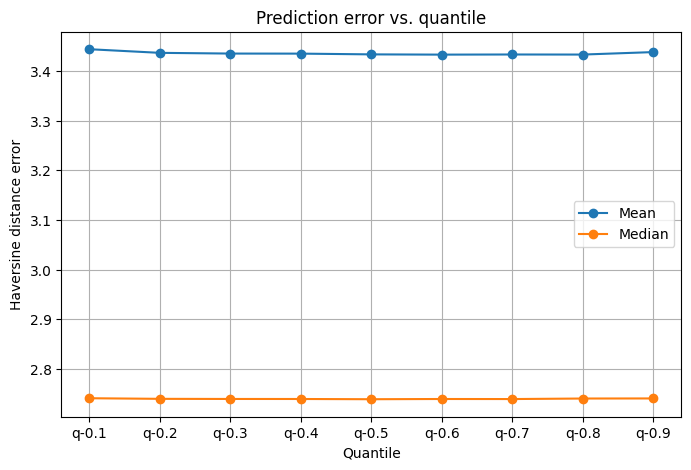

In [34]:
plt.figure(figsize=(8,5))
plt.plot(df_stats["quantile"], df_stats["mean"], marker="o", label="Mean")
plt.plot(df_stats["quantile"], df_stats["median"], marker="o", label="Median")
plt.xlabel("Quantile")
plt.ylabel("Haversine distance error")
plt.title("Prediction error vs. quantile")
plt.legend()
plt.grid(True)
plt.show()